In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from google.colab import drive
import random
drive.mount('/content/drive')

from statsmodels.graphics.tsaplots import plot_acf
from pandas_datareader import data as pdr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dynamic Asset Allocation with Macroeconomic-Informed Neural Networks
### DS4420 Final Project: Max Cernosia, Armaan Pruthi

## Reading data

In [38]:
start_date = "2015-10-01"
end_date = "2024-10-31"

# Get the data
cpi = pdr.get_data_fred("MEDCPIM158SFRBCLE", start=start_date, end=end_date) # Change in CPI
unrate = pdr.get_data_fred("UNRATE", start=start_date, end=end_date) # Unemployment Rate
dff = pdr.get_data_fred("DFF", start=start_date, end=end_date) # Federal Funds Rate
vix = pdr.get_data_fred("VIXCLS", start=start_date, end=end_date) # Vix
pce = pdr.get_data_fred("PCE", start=start_date, end=end_date) # Personal consumption
psavert = pdr.get_data_fred("PSAVERT", start=start_date, end=end_date) # Personal savings rate

# Interpolate GDP to monthly from quarterly
gdp = pdr.get_data_fred("GDP", start=start_date, end=end_date) # Quarterly GDP
gdp_monthly = gdp.resample("MS").asfreq().interpolate(method='linear')
gdp_change = gdp_monthly.pct_change() # % change in GDP MOM

# resampling other data to month start
cpi = cpi.resample("MS").asfreq()
unrate = unrate.resample("MS").asfreq()
dff = dff.resample("MS").asfreq()
vix = vix.resample("MS").asfreq()
pce = pce.resample("MS").asfreq()
psavert = psavert.resample("MS").asfreq()

# Calculate percent changes in consumption and saving
psave_change = psavert.pct_change() # Change in personal savings rate
pconsum_change = pce.pct_change() # % change in personal consumption

# Combining
macro_df = pd.concat([
    psavert,
    gdp_change.rename(columns={'GDP': 'gdp_change'}),
    pconsum_change.rename(columns={'PCE': 'pconsum_change'}),
    psave_change.rename(columns={'PSAVERT': 'psave_change'}),
    cpi.rename(columns={'MEDCPIM158SFRBCLE': 'cpi'}),
    unrate.rename(columns={'UNRATE': 'unrate'}),
    dff.rename(columns={'DFF': 'dff'})
], axis=1)

macro_df.dropna(inplace=True)

In [ ]:
macro_df.head()

,PSAVERT,gdp_change,pconsum_change,psave_change,cpi,unrate,dff
DATE,,,,,,,
2015-11-01,5.6,0.001642,0.002283,-0.034483,2.265481,5.1,0.07
2015-12-01,5.8,0.001639,0.002318,0.035714,1.834720,5.0,0.13
2016-01-01,6.1,0.001636,0.002088,0.051724,2.708417,4.8,0.20
2016-02-01,5.6,0.003343,0.006131,-0.081967,2.537714,4.9,0.38
2016-03-01,5.9,0.003331,-0.001394,0.053571,2.222005,5.0,0.36


# Calculating Optimal Stockweight (Labels y)
- What stock weight would have given me the best risk adjusted return this month
- Calculate risk / volatility of returns for the stocks and bonds
- Use actual return and current risk free rate to calculate risk premium
- Use closed form to calculate optimal weight of stock for that month.
- Use as label for the start of month values.

In [ ]:
sp500_daily = pdr.get_data_fred('SP500', start=start_date, end=end_date)
bond_daily = pdr.get_data_fred('BAMLCC0A0CMTRIV', start=start_date, end=end_date)

rf = pdr.get_data_fred('SOFR', start='2015-10-01', end='2024-09-30')
rf.columns = ['SOFR']
rf_daily = rf.resample('D').ffill()

index_df = pd.concat([sp500_daily, bond_daily, rf_daily], axis=1).dropna()

In [ ]:
index_df.head()

,SP500,BAMLCC0A0CMTRIV,SOFR
DATE,,,
2018-04-03,2614.45,2839.35,1.83
2018-04-04,2644.69,2838.79,1.74
2018-04-05,2662.84,2834.57,1.75
2018-04-06,2604.47,2845.92,1.75
2018-04-09,2613.16,2846.51,1.75


In [ ]:
index_df['SP500_return'] = index_df['SP500'].pct_change()
index_df['Bond_return'] = index_df['BAMLCC0A0CMTRIV'].pct_change()

# Resample to monthly
monthly_groups = index_df.resample('ME')

closed_form_weights = []
return_variances = []
for date, group in monthly_groups:

    # Realized returns
    mu_s = group['SP500_return'].mean()
    mu_b = group['Bond_return'].mean()
    sigma_s = group['SP500_return'].std()
    sigma_b = group['Bond_return'].std()
    rho = group['SP500_return'].corr(group['Bond_return'])

    # Monthly risk-free rate
    rf_month = group['SOFR'].iloc[-1] / 100 / 12

    # Excess returns
    mu_s_excess = mu_s - rf_month
    mu_b_excess = mu_b - rf_month

    # Closed-form numerator & denominator
    numerator = mu_s_excess * sigma_b**2 - mu_b_excess * rho * sigma_s * sigma_b
    denominator = (
        mu_s_excess * sigma_b**2 +
        mu_b_excess * sigma_s**2 -
        (mu_s_excess + mu_b_excess) * rho * sigma_s * sigma_b
    )
    if denominator == 0 or np.isnan(denominator):
        w_star = np.nan
    else:
        w_star = numerator / denominator
        w_star = np.clip(w_star, 0, 1)
    closed_form_weights.append({
        'Date': date,
        'optimal_stock_w': w_star
    })
    return_variances.append({
        'Date': date,
        'stock_return_std': sigma_s,
        'bond_return_std': sigma_b
    })
stock_w = pd.DataFrame(closed_form_weights).set_index('Date')
return_var = pd.DataFrame(return_variances).set_index('Date')

stock_w.dropna(inplace=True)
stock_w.index = stock_w.index - pd.offsets.MonthEnd(1) + pd.offsets.MonthBegin(1)

In [ ]:
# Create dataframe for previous month return standard deviations
clean_return_var = return_var.copy()
clean_return_var.index = return_var.index + pd.offsets.MonthBegin(1)
clean_return_var.head(), return_var.head()
clean_return_var.rename(columns={'stock_return_std': 'sp500_prev_month_std',
                             'bond_return_std': 'bond_prev_month_std'}, inplace=True)

stock_w.head()

,optimal_stock_w
Date,
2018-04-01,0.038086
2018-05-01,0.176653
2018-06-01,0.206430
2018-07-01,0.000000
2018-08-01,0.094574


## Add stock and bond index data to input matrix

In [ ]:
month_starts = macro_df.index

# Getting month start values for S&P500 and bond portfolio returns.
index_at_month_start = index_df.reindex(month_starts, method='ffill')
index_monthly = index_at_month_start[[
    'SP500', 'SP500_return', 'BAMLCC0A0CMTRIV',
    'Bond_return','SOFR'
]]

# Merge w/ macro data to be used for our input layer
df_merged = macro_df.join(index_monthly, how='inner')

# Add monthly return data
monthly_returns = index_df.resample('ME').apply({
    'SP500': lambda x: x.iloc[-1] / x.iloc[0] - 1,
    'BAMLCC0A0CMTRIV': lambda x: x.iloc[-1] / x.iloc[0] - 1
}).rename(columns={
    'SP500': 'sp500_prev_month_return',
    'BAMLCC0A0CMTRIV': 'bond_prev_month_return'
})
monthly_returns.index = monthly_returns.index + pd.offsets.MonthBegin(1)
df_merged = df_merged.join([monthly_returns, stock_w, clean_return_var], how='inner')
df_merged.columns

Index(['PSAVERT', 'gdp_change', 'pconsum_change', 'psave_change', 'cpi',
       'unrate', 'dff', 'SP500', 'SP500_return', 'BAMLCC0A0CMTRIV',
       'Bond_return', 'SOFR', 'sp500_prev_month_return',
       'bond_prev_month_return', 'optimal_stock_w', 'sp500_prev_month_std',
       'bond_prev_month_std'],
      dtype='object')

In [ ]:
df_merged.rename(columns={
    'SP500': 'sp500_index_value',
    'SP500_return': 'sp500_prev_day_return',
    'BAMLCC0A0CMTRIV': 'bond_index_value',
    'Bond_return': 'bond_prev_day_return',
    'SOFR': 'sofr',
    'PSAVERT': 'psavert'

}, inplace=True)

print(df_merged.shape)
df_merged.head()

(77, 17)


,psavert,gdp_change,pconsum_change,psave_change,cpi,unrate,dff,sp500_index_value,sp500_prev_day_return,bond_index_value,bond_prev_day_return,sofr,sp500_prev_month_return,bond_prev_month_return,optimal_stock_w,sp500_prev_month_std,bond_prev_month_std
2018-05-01,6.0,0.003528,0.004813,0.000000,2.981833,3.8,1.70,2654.80,0.002549,2812.07,-0.003335,1.76,0.012852,-0.006294,0.176653,0.009703,0.002091
2018-06-01,6.3,0.003515,0.001827,0.050000,2.632118,4.0,1.70,2734.62,0.010849,2822.76,-0.004029,1.81,0.019011,0.007863,0.206430,0.006550,0.002815
2018-07-01,6.5,0.003503,0.003187,0.031746,2.111494,3.8,1.91,2718.37,0.000758,2818.58,0.000429,2.12,-0.005942,-0.001481,0.000000,0.005575,0.001892
2018-08-01,6.6,0.001909,0.002805,0.015385,2.296711,3.8,1.91,2813.36,-0.001040,2833.24,-0.002299,1.88,0.032853,0.008173,0.094574,0.005448,0.001699
2018-09-01,6.8,0.001906,0.000271,0.030303,2.333723,3.7,1.91,2901.52,0.000134,2855.22,-0.000252,1.97,0.031336,0.007758,0.182709,0.004431,0.001621


## Normalizing Data

In [68]:
#df_merged = pd.read_csv('/content/drive/My Drive/Colab Notebooks/project_data.csv').set_index("Unnamed: 0")
seed = 0
random.seed(seed)

# Split into input data and target
X = df_merged[[col for col in df_merged.columns if col != 'optimal_stock_w']]
y = df_merged['optimal_stock_w']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
df_merged.head()

,psavert,gdp_change,pconsum_change,psave_change,cpi,unrate,dff,sp500_index_value,sp500_prev_day_return,bond_index_value,bond_prev_day_return,sofr,sp500_prev_month_return,bond_prev_month_return,optimal_stock_w,sp500_prev_month_std,bond_prev_month_std
Unnamed: 0,,,,,,,,,,,,,,,,,
2015-11-01,5.6,0.001642,0.002283,-0.034483,2.265481,5.1,0.07,2079.36,-0.004810,2607.24,0.001340,0.08,0.080850,0.004934,0.038078,0.008238,0.002497
2015-12-01,5.8,0.001639,0.002318,0.035714,1.834720,5.0,0.13,2102.63,0.010681,2611.72,0.003952,0.21,-0.011235,-0.000914,0.143540,0.008190,0.001469
2016-01-01,6.1,0.001636,0.002088,0.051724,2.708417,4.8,0.20,2043.94,-0.009412,2578.89,0.001340,0.16,-0.027913,-0.012570,0.258178,0.011601,0.003416
2016-02-01,5.6,0.003343,0.006131,-0.081967,2.537714,4.9,0.38,1939.38,-0.000443,2583.20,-0.002587,0.35,-0.035982,0.002202,0.000000,0.015221,0.002073
2016-03-01,5.9,0.003331,-0.001394,0.053571,2.222005,5.0,0.36,1978.35,0.023869,2599.63,-0.003679,0.33,-0.003687,0.010077,0.240043,0.011701,0.002711


## Training model

In [ ]:
# Initialize model
model = Sequential([
    Dense(32, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Train model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mse'])

history = model.fit(X_train_scaled, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 353ms/step - loss: 0.1717 - mse: 0.1717 - val_loss: 0.1260 - val_mse: 0.1260
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 0.1588 - mse: 0.1588 - val_loss: 0.1141 - val_mse: 0.1141
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1416 - mse: 0.1416 - val_loss: 0.1034 - val_mse: 0.1034
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1226 - mse: 0.1226 - val_loss: 0.0935 - val_mse: 0.0935
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1131 - mse: 0.1131 - val_loss: 0.0849 - val_mse: 0.0849
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1150 - mse: 0.1150 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1044 - mse: 0.1044 - val_loss: 0.0704 - val_mse: 0.0704
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1070 - mse: 0.1070 - val_loss: 0.0646 - val_mse: 0.0646
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0809 - mse

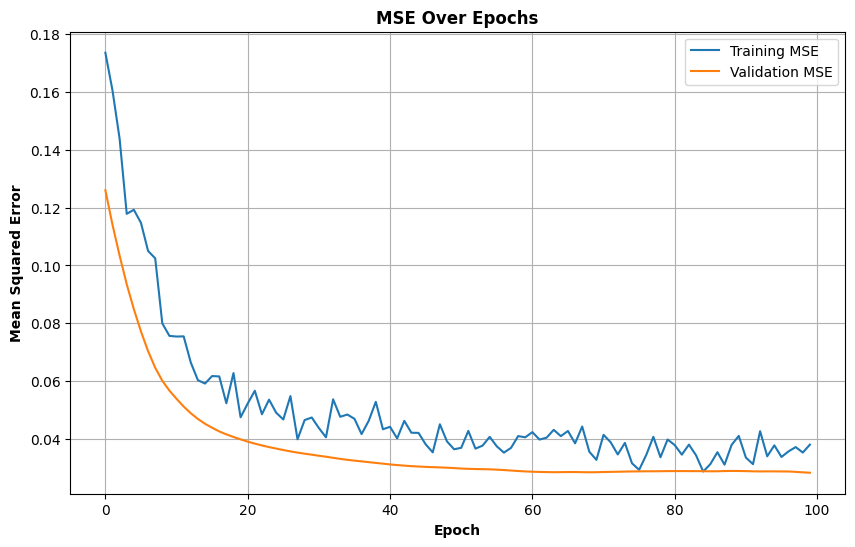

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Correlation: 0.4265


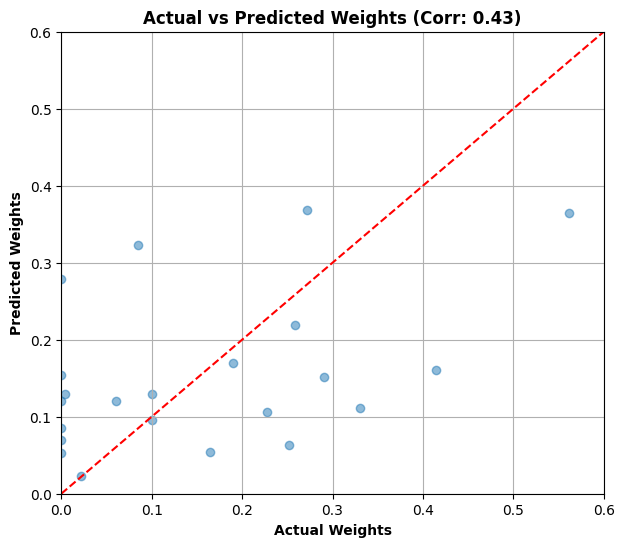

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('MSE Over Epochs', weight='semibold')
plt.xlabel('Epoch', weight='semibold')
plt.ylabel('Mean Squared Error', weight='semibold')
plt.legend()
plt.grid(True)
plt.show()

y_pred = model.predict(X_test_scaled).flatten()

correlation = np.corrcoef(y_test, y_pred)[0, 1]
print(f"Correlation: {correlation:.4f}")

plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual Weights", weight='semibold')
plt.ylabel("Predicted Weights", weight='semibold')
plt.title(f"Actual vs Predicted Weights (Corr: {correlation:.2f})", weight='semibold')
plt.xlim((0, 0.6))
plt.ylim((0, 0.6))
plt.grid(True)
plt.show()


## Incorporating time series forecasts into model.

In [98]:
# rading data and reordering columns for MLP
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/time_series_forecasts.csv').drop('Unnamed: 0', axis=1)
df = df[['PSAVERT', 'gdp_change', 'pconsum_change', 'psave_change', 'cpi',
         'unrate', 'dff', 'SP500', 'SP500_return', 'BAMLCC0A0CMTRIV', 'Bond_return',
         'SOFR', 'SP500_Prev_Month_Return', 'Bond_Prev_Month_Return']]

df.rename(columns = {'BAMLCC0A0CMTRIV': 'bond_index_value',
                     'SOFR': 'sofr',
                     'PSAVERT': 'psavert',
                     'Bond_return': 'bond_prev_day_return',
                     'Bond_Prev_Month_Return': 'bond_prev_month_return',
                     'SP500': 'sp500_index_value',
                     'SP500_return': 'sp500_prev_day_return',
                     'SP500_Prev_Month_Return': 'sp500_prev_month_return',},
          inplace=True)

# For vars where time series wasn't great, just using most recent month value
df['sp500_prev_month_std'] = df_merged.iloc[-4,:]['sp500_prev_month_std']
df['bond_prev_month_std'] = df_merged.iloc[-4,:]['bond_prev_month_std']

# Getting labels from actual dataset
y = df_merged.iloc[-3: ,]['optimal_stock_w']
df_merged.iloc[-3: ,].index

Index(['2024-07-01', '2024-08-01', '2024-09-01'], dtype='object', name='Unnamed: 0')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


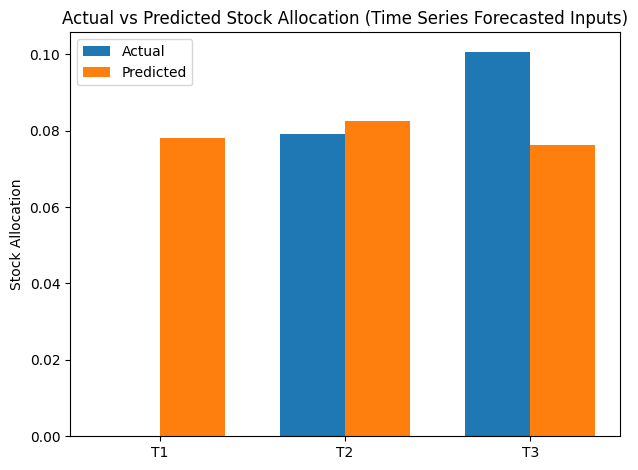

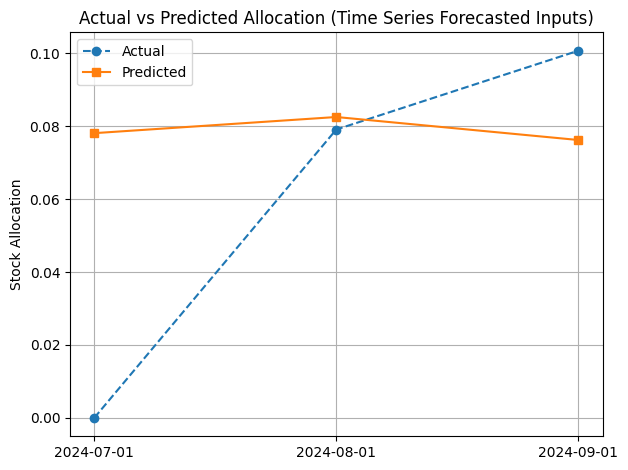

In [101]:
# Scaling and making predictions
df_scaled = scaler.transform(df)
ts_pred = model.predict(df_scaled).flatten()

# Plotting
x = np.arange(3)
width = 0.35

plt.bar(x - width/2, y, width, label='Actual')
plt.bar(x + width/2, ts_pred, width, label='Predicted')
plt.xticks(x, [f'T{t+1}' for t in x])
plt.ylabel('Stock Allocation')
plt.title('Actual vs Predicted Stock Allocation (Time Series Forecasted Inputs)')
plt.legend()
plt.tight_layout()
plt.show()


plt.plot(range(3), y, marker='o', label='Actual', linestyle='--')
plt.plot(range(3), ts_pred, marker='s', label='Predicted', linestyle='-')
plt.xticks(range(3), df_merged.iloc[-3: ,].index)
plt.ylabel('Stock Allocation')
plt.title('Actual vs Predicted Allocation (Time Series Forecasted Inputs)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
